In [134]:
import os
import argparse
import re

import logging
#import yaml
import time
import random
import pandas as pd
import numpy as np
import string 
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim import corpora
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.wrappers import DtmModel
from gensim import matutils
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

In [135]:
# set working directory
os.chdir("/home/mrh1996/LDA_COVID_Tweets")

In [136]:
neuro_waves = pd.read_csv('../projects/neuro_waves_diagnoses.csv')
neuro_waves_neuroicd = pd.read_csv('../projects/neuro_waves_neuroicd.csv')

In [137]:
neuro_waves = neuro_waves[['patient_num', 'start_datetime', 'diagnosis_code', 'diagnosis_name','month']]
neuro_waves_neuroicd = neuro_waves_neuroicd[['patient_num', 'start_datetime', 'diagnosis_code', 'diagnosis_name','month']]

In [138]:
!chmod 755 -R '/home/mrh1996/LDA_COVID_Tweets/dtm-linux64'

In [139]:
dx_codes = neuro_waves_neuroicd['diagnosis_code']

# be sure to split sentence before feed into Dictionary
dx_codes = [d.split() for d in dx_codes]

dictionary = corpora.Dictionary(dx_codes)

doc_term_matrix = [dictionary.doc2bow(doc) for doc in dx_codes]

In [140]:
neuro_waves['start_datetime'] = pd.to_datetime(neuro_waves['start_datetime'] + ' 2020', format='%Y-%m-%d', errors='coerce')
neuro_waves_neuroicd['start_datetime'] = pd.to_datetime(neuro_waves_neuroicd['start_datetime'] + ' 2020', format='%Y-%m-%d', errors='coerce')

In [141]:
time_seq = neuro_waves_neuroicd[['diagnosis_code', 'start_datetime']].groupby(pd.Grouper(key='start_datetime', freq='1M')).agg('count') # groupby each 1 month
time_seq = time_seq.reset_index()
time_seq = time_seq['diagnosis_code'] # not actually diangosis name but the count

In [133]:
time_seq

0      47
1     365
2     248
3     166
4      86
5      60
6      95
7     147
8     463
9     463
10    327
11     38
Name: diagnosis_code, dtype: int64

In [131]:
def validate(topic_term, top_k):
    topic_term = np.exp(topic_term)
    topic_term = topic_term / topic_term.sum()
    topic_term = topic_term * top_k
    return topic_term

def get_topics(topic_terms, topic_number):
    topic_terms = topic_terms[topic_number]
    bestn = matutils.argsort(topic_terms, 20, reverse=True)
    beststr = [dictionary[id_] for id_ in bestn]
    return beststr

# next is the vocabulary, which we already have
vocab = []
for i in range(0, len(dictionary)):
    vocab.append(dictionary[i])

# we now need term-frequency and doc_lengths

def term_frequency(doc_term_matrix, dictionary):
    term_frequency = [0] * len(dictionary)
    doc_lengths = []
    for doc in doc_term_matrix:
        doc_lengths.append(len(doc))
        for pair in doc:
            term_frequency[pair[0]] += pair[1]
    return term_frequency, doc_lengths

In [142]:
start = time.time()

results = []
top_k = 8

for t in range(1, top_k):
        
        print(t)
        cov_model = DtmModel('/home/mrh1996/LDA_COVID_Tweets/dtm-linux64', doc_term_matrix, time_seq, num_topics= t,
                             id2word=dictionary, initialize_lda=True, rng_seed = 1833)
        
        topic_term = cov_model.lambda_[:,:,0] # the lambda matrix contains 
        
        topic_term = validate(topic_term, t)
        
        #topics_wrapper = []
        #for i in range(0, t):
        #    topics_wrapper.append(get_topics(topic_term, i))
        #print(len(topics_wrapper))
        
        for i in range(0, (len(time_seq)-1)):
            coherence_topics = cov_model.dtm_coherence(time=i)
            cm_wrapper_cv = CoherenceModel(topics=coherence_topics, texts=dx_codes, dictionary=dictionary, coherence='c_v')
            score = cm_wrapper_cv.get_coherence()
            print(score)
            tup = t, i, score
            results.append(tup)

        lda_results = pd.DataFrame(results, columns=['topic', 'time', 'score'])
        
end = time.time()
print((end - start)/60)

1


/home/mrh1996/.conda/envs/lda_covid_tweets/lib/python3.6/site-packages/gensim/models/wrappers/dtmmodel.py:498: UserWarning: The parameter `num_words` is deprecated, will be removed in 4.0.0, use `topn` instead.
  warnings.warn("The parameter `num_words` is deprecated, will be removed in 4.0.0, use `topn` instead.")


0.8600247743011247
0.8600247743011247
0.8600247743011247
0.8600247743011247
0.8600247743011247
0.8600247743011247
0.8600247743011247
0.8600247743011247
0.8600247743011247
0.8600247743011247
0.8600247743011247
2
0.8409406693464592
0.8409406693464592
0.8409406693464592
0.8409406693464592
0.8409406693464592
0.8409406693464592
0.8409406693464592
0.8409406693464592
0.8409406693464592
0.840940669346459
0.840940669346459
3
0.8271942220133642
0.8271942220133642
0.8271942220133642
0.8271942220133642
0.8271942220133642
0.8271942220133642
0.8271942220133642
0.8271942220133642
0.8271942220133642
0.8271942220133642
0.8271942220133642
4
0.8183364075548263
0.8183364075548263
0.8183364075548263
0.8183364075548263
0.8183364075548263
0.8183364075548263
0.8183364075548263
0.8183364075548263
0.8183364075548263
0.8183364075548263
0.8183364075548263
5
0.8135211731066041
0.8135211731066041
0.8135211731066041
0.8135211731066041
0.8135211731066041
0.8135211731066041
0.8132601820699017
0.8132601820699017
0.8135

In [ ]:
top_k#time_seq

In [ ]:
cov_model.print_topics()

In [ ]:
cov_model.dtm_vis(doc_term_matrix, time = 2)[4]

In [ ]:
cov_model.show_topic(topicid = 0, time = 1, topn=10, num_words=None)

In [143]:
def format_topics(topicid_num, time_slice, num_words, time_label, topic_label):
    
    top_mat = cov_model.show_topic(topicid = topicid_num, time = time_slice, topn=num_words)
    top_df = pd.DataFrame(top_mat)
    top_df['time'] = time_label
    top_df["topic"] = topic_label
    top_df.columns = ['probability', 'term', 'time', 'topic']
    
    return(top_df)


results = []

num_topics = 7
time_seq = 12

for i in range(0, num_topics):
    for t in range(0, time_seq):
        top_df = format_topics(topicid_num = i, time_slice = t, num_words = 6, time_label = t, topic_label = i)
        results.append(top_df)


all_results = pd.concat(results).reset_index()
all_results.head(10)

,index,probability,term,time,topic
0,0,0.319323,I62.00,0,0
1,1,0.233875,G72.81,0,0
2,2,0.171007,G40.89,0,0
3,3,0.113121,G40.911,0,0
4,4,0.036852,I60.8,0,0
5,5,0.027262,G72.41,0,0
6,0,0.319635,I62.00,1,0
7,1,0.234108,G72.81,1,0
8,2,0.171003,G40.89,1,0
9,3,0.113105,G40.911,1,0


In [82]:
len(all_results)

504

In [144]:
# bind icd descriptions
all_results = all_results.rename(columns={"term": "diagnosis_code"})

all_results.head()

,index,probability,diagnosis_code,time,topic
0,0,0.319323,I62.00,0,0
1,1,0.233875,G72.81,0,0
2,2,0.171007,G40.89,0,0
3,3,0.113121,G40.911,0,0
4,4,0.036852,I60.8,0,0


In [145]:
codes = neuro_waves[['diagnosis_code', 'diagnosis_name']].drop_duplicates()
codes.head()
print(len(codes))

codes = codes.groupby(['diagnosis_code']).first()

len(codes)

7978


7577

In [146]:
all_results = pd.merge(all_results, codes, on = 'diagnosis_code', how = 'inner')
len(all_results)

504

In [147]:
all_results["icd_code"] = all_results["diagnosis_code"] + ": " + all_results["diagnosis_name"]

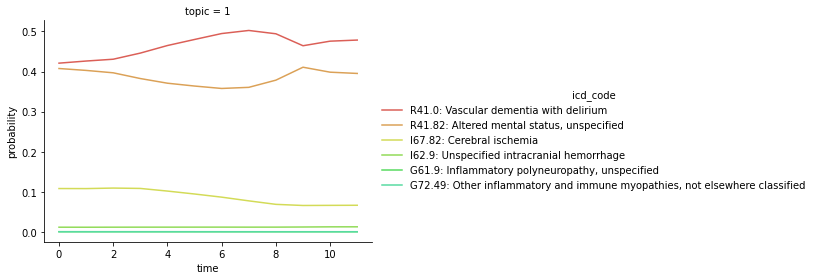

In [154]:
import seaborn as sns

rocket_palette = sns.color_palette("hls", 12)

all_results_top1 = all_results[all_results['topic'] == 1]

dtm_plot2 = sns.FacetGrid(all_results_top1, col="topic", col_wrap=1, hue='icd_code', palette = rocket_palette, height=4, aspect=1.5)
dtm_plot2.map_dataframe(sns.lineplot, x="time", y="probability")
dtm_plot2.add_legend()

#dtm_plot2.savefig('figures/topic8_50000.svg')

In [ ]:
rocket_palette = sns.color_palette("rocket_r")

dtm_plot2 = sns.FacetGrid(lda_results, col="time", col_wrap=5, hue='time', palette = rocket_palette)
dtm_plot2.map_dataframe(sns.lineplot, x="topic", y="score" )

In [ ]:
!pip install pyLDAvis==2.1.2

In [ ]:
vis_wrapper = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_wrapper)